# Introduction

This tutorial is intended to demonstrate how to craft model predictive control (MPC) strategies manually in Python using [CasADi](https://web.casadi.org/docs/). It assumes that you have a basic understanding of coding structure in Python and background on optimization and control. Resources provided below may be used to learn more. Blog posts on [CasADi's blog section](https://web.casadi.org/blog/) are also useful in using CasADi to craft optimization problems.

* [Solving Nonlinear Programs with CasADi's Opti Stack](https://web.casadi.org/blog/opti/)
* [Formulating Optimal Control Problems with CasADi's Opti Stack](https://web.casadi.org/blog/ocp/)

## Resources
MPC books 
* [Model Predictive Control - Rawlings](https://sites.engineering.ucsb.edu/~jbraw/mpc/)
* [Predictive Control for Linear and Hybrid Systems - Borrelli](https://sites.google.com/berkeley.edu/mpc-lab/mpc-course-material?pli=1)

## Other Python Tools
For developing your own MPC strategies, it is recommended to construct your own controllers using the method described in this tutorial. However, off-the-shelf tools exist to generate and simulate controllers for pre-defined problems. The following list includes some of these tools:
* [Pyomo](https://pyomo.readthedocs.io/en/stable/)
* [do-mpc](https://www.do-mpc.com/en/latest/)

### Copyright and Use
This tutorial was created by Kimberly J. Chan for the Mesbah Lab group at the University of California, Berkeley.

Created: March 30, 2023

Last Modified: April 26, 2023

(c) Mesbah Lab 2023


Note: This tutorial is intended to be run using Google Colab, but the same principles apply when running on your own machine.

In [1]:
#@title Install CasADi
!pip install casadi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#@title Import Relevant Packages
import numpy as np
import matplotlib.pyplot as plt
import casadi as cas

# CasADi

[CasADi](https://web.casadi.org) is a "tool for nonlinear optimization and algorithmic differentiation."

It uses a **symbolic framework** to aid in formulating optimization problems and algorithmic differentiation. Symbols in code are used to denote a variable that the computer/solver/algorithm will determine. They do not have an intrinsic value.

In [3]:
# creating a casadi symbol
x = cas.SX.sym('x') # this will be a 1x1 "matrix", scalar
x

SX(x)

In [4]:
# creating a casadi symbol
x = cas.SX.sym('x',5) # this will be a 5x1 "matrix", vector
x

SX([x_0, x_1, x_2, x_3, x_4])

In [5]:
# creating a casadi symbol
x = cas.SX.sym('x',3,5) # this will be a 3x5 matrix
x

SX(
[[x_0, x_3, x_6, x_9, x_12], 
 [x_1, x_4, x_7, x_10, x_13], 
 [x_2, x_5, x_8, x_11, x_14]])

The use of *symbols* allows **expressions** to be easily defined in code.

In [6]:
x = cas.SX.sym('x')
y = cas.SX.sym('y')
# example of casadi expression
cas.sqrt(x+y**2) # the result is a symbolic representation of the expression (which would result in a scalar output)

SX(sqrt((x+sq(y))))

Symbolic expressions can be used as a tool to create CasADi functions. CasADi functions can then be used elsewhere. CasADi functions are similar to function definitions in Python, but since the backend of CasADi is based in C with less overhead than common matrix packages (e.g., NumPy), it can sometimes be advantageous to use CasADi to formulate functions so that other codes can run faster.

In [7]:
x = cas.SX.sym('x')
y = cas.SX.sym('y')
# example of casadi expression
out = cas.sqrt(x+y**2)
# create a casadi function
# the order of arguments is: name, [inputs to Function], [outputs of Function]
f = cas.Function('f', [x,y], [out])
# the output is a pointer or reference to the casadi function
# it can be used as a function call

a = 3.0
b = 7.5
print('f(a,b): ', f(a,b)) # this result is a "dense" matrix (DM), which is how casadi represents variables with actual value
# you can get a numpy representation of such a value by using the full function
print('f(a,b).full(): ', f(a,b).full())
print('type(f(a,b).full()): ', type(f(a,b).full()))

f(a,b):  7.6974
f(a,b).full():  [[7.69740216]]
type(f(a,b).full()):  <class 'numpy.ndarray'>


# Model Predictive Control

Model predictive control (MPC) is an optimization-based control strategy. The basis of MPC revolves around an optimal control problem (OCP). The OCP is an optimization problem that describes the objective of the control constrained on the dynamics and other constraints of the system. The decision variables of an OCP determine the optimal set of manipulated variables or control inputs to the system.

An example of an OCP is given as
$$
\begin{align}
\min_{\mathbf{u},\mathbf{x}} &~~ V(\mathbf{x},\mathbf{u}) \\
&~~ x_{k+1} = f(x_{k}, u_{k}), \\
&\quad\quad \forall k = 0,\ldots, N-1, \\
&~~ \mathbf{x} \in \mathcal{X}, \mathbf{u} \in \mathcal{U}, \\
&~~ x_{0} = x(0), \\
&~~ \mathbf{x} = \{x_0,\ldots,x_N\}, \\
&~~ \mathbf{u} = \{u_0,\ldots,u_{N-1}\},
\end{align} 
$$
where $V(\mathbf{u},\mathbf{x})$ is the objective of the control (formulated as a cost), $u$ and $x$ represent the inputs and states of the system, respectively, $f(\cdot)$ represent the one-step-ahead prediction of the states (dynamics of the system), $\mathcal{X}$ and $\mathcal{U}$ are compact sets from which the states and inputs, respectively, are allowed, $x(0)$ is the initial state of the system, and $N$ is the horizon of the control.

**The core idea of MPC is to solve some finite-time OCP at each time step. The optimal inputs obtained from the solution of this OCP are used to control the system. Typically, only the first optimal input is used. Then, feedback from the system is incorporated into the next OCP.**

# CasADi Opti

The Opti stack is a set of helper functions within CasADi that make the construction of optimization problems more user-friendly.

| Optimization Problem Component/Function | Opti Helper |
|          :----:        |       :----:        |
| Decision Variable      | `opti.variable()`   |
| Parameter              | `opti.parameter()`  |
| Minimize Objective     | `opti.minimize()`   |
| Add Constraint         | `opti.subject_to()` |

# Example Problem: Double Integrator Model
A model for the discretized double integrator is as follows:
\begin{align*}
\underbrace{\begin{bmatrix}x^1(i+1) \\ x^2(i+1)\end{bmatrix}}_{x(i+1)} & = \underbrace{\begin{bmatrix}1 & 1 \\ 0 & 1 \end{bmatrix}}_A \underbrace{\begin{bmatrix}x^1(i) \\ x^2(i)\end{bmatrix}}_{x(i)} +  \underbrace{\begin{bmatrix}0.5 \\ 1 \end{bmatrix}}_B u(i) \\
y(i) & = \underbrace{\begin{bmatrix} 1 & 0 \end{bmatrix}}_C  \underbrace{\begin{bmatrix}x^1(i) \\ x^2(i)\end{bmatrix}}_{x(i)}
\end{align*}


We wish to solve:

\begin{align}
\min_{\mathbf{u},\mathbf{x}} &~~ x_N^\top Q_N x_N + \sum_{k=0}^{N-1} x_k^\top Q x_k + u_k^\top R u_k, \\
&~~ x_{k+1} = Ax_{k} + Bu_{k}, \\
&~~ y_{k} = Cx_{k}, \\
&~~ \mathbf{y} \in [-1,1], \mathbf{u} \in [-1,1], \\
&~~ x_{0} = x(0), \\
&~~ \mathbf{x} = \{x_0,\ldots,x_N\}, \\
&~~ \mathbf{u} = \{u_0,\ldots,u_{N-1}\},
\end{align} 

where $\sum_{k=0}^{N-1} x_k^\top Q x_k + u_k^\top R u_k$ is known as the stage cost (cost incurred at each stage of the prediction horizon) and $x_N^\top Q_N x_N$ is the terminal cost (cost incurred for the final state).

Helper CasADi functions can help formulate the problem in a more succinct manner.


In [8]:
#@title Create CasADi function(s) for the model
nx = 2 # number of states
nu = 1 # number of inputs
ny = 1 # number of outputs
x = cas.SX.sym('x', nx)
u = cas.SX.sym('u', nu)

A = np.array([[1, 1],
              [0, 1]]) # 2x2 numpy array
B = np.array([[0.5],
              [1.0]]) # 2x1 numpy array
C = np.array([[1, 0]]) # 1x2 numpy array

xnext = A@x + B@u # the @ symbol is an overloaded function that performs matrix multiplication in Python
f = cas.Function('f', [x,u], [xnext]) # equation for the state evolution

y = C@x
h = cas.Function('h', [x], [y]) # equation for the output

In [9]:
#@title Create CasADi function(s) for the cost(s)/objective

# define weights for the cost components -- these are tunable!
Q = np.eye(nx)
R = np.eye(nu)
QN = np.eye(nx)

lstg = x.T@Q@x + u.T@R@u
stage_cost = cas.Function('stage_cost', [x,u], [lstg]) # function for the cost of each stage

lterm = x.T@QN@x
term_cost = cas.Function('term_cost', [x], [lterm]) # function for the terminal cost

We define the input and output constraints as:

\begin{align*}
|u_k| & \leq 1 \qquad \forall k = 0, 1, 2, \ldots, N-1 \\
|y_k| & \leq 1 \qquad \forall k = 0, 1, 2, \ldots, N-1
\end{align*}

In [10]:
Ubound = 1.0
Ybound = 1.0
umin = -Ubound * np.ones((nu,1))
umax = Ubound * np.ones((nu,1))
ymin = -Ybound * np.ones((ny,1))
ymax = Ybound * np.ones((ny,1))

# we can also set the initial values of the decision variables
u_init = np.zeros(nu)
x_init = np.zeros(nx)
y_init = np.zeros(ny)

In [11]:
#@title Use CasADi Opti to define the optimization problem
Np = 10 # prediction horizon
x0 = np.array([-0.75,0.75]).reshape(-1,1)

opti = cas.Opti()

# the decision variables of the OCP include the predicted states, inputs, and
# outputs at each stage in the prediction horizon
# you can create container variables to keep track of the assignment of code variables
X = [0 for _ in range(Np+1)]
U = [0 for _ in range(Np)]
Y = [0 for _ in range(Np+1)]

# we can add the initial state as a parameter of the OCP since it is fixed
X[0] = opti.parameter(nx)
opti.set_value(X[0], x0)

# decision variable y_{0}
Y[0] = opti.variable(ny)
opti.subject_to(Y[0] == h(X[0]))

J = 0 # initialize the cost/objective

# the remaining decision variables can be added iteratively via for loop
for k in range(Np):
    # decision variable u_{k}
    U[k] = opti.variable(nu)
    opti.subject_to(opti.bounded(umin, U[k], umax))
    opti.set_initial(U[k], u_init)

    # the stage cost can be incrementally added within the for loop; this is 
    # facilitated by our stage cost function from above
    J += stage_cost(X[k], U[k])

    # decision variable x_{k+1}
    X[k+1] = opti.variable(nx)
    # opti.subject_to(opti.bounded(xmin, X[k+1], xmax)) # uncomment if there are bounds on the state
    opti.set_initial(X[k+1], x_init)

    # decision variable y_{k+1}
    Y[k+1] = opti.variable(ny)
    opti.subject_to(opti.bounded(ymin, Y[k+1], ymax))
    opti.set_initial(Y[k+1], y_init)

    # dynamics constraint
    opti.subject_to(X[k+1] == f(X[k], U[k]))
    
    # output equation constraint
    opti.subject_to(Y[k+1] == h(X[k+1]))

    # other constraints can also be added in this loop, e.g., constraints
    # restricting the magnitude of the change in input from one stage to another

# add terminal cost
J += term_cost(X[-1])

# set the cost/objective to be minimized
opti.minimize(J)

# set the options for the solver
p_opts = {'verbose': 0,
          'expand': True,
          'print_time': 1}
s_opts = {'max_iter': 1000,
          'print_level': 1,
          'tol': 1e-6}
# set the solver
opti.solver('ipopt', p_opts, s_opts)

In [12]:
#@title Solve the optimization problem
sol = opti.solve()

# you can extract the values of the decision variables after the solve has
# completed using the same references used in defining the problem
Usol = np.asarray([sol.value(u) for u in U]).reshape(-1,nu).T
Xsol = np.asarray([sol.value(x) for x in X]).reshape(-1,nx).T
Ysol = np.asarray([sol.value(y) for y in Y]).reshape(-1,ny).T


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  61.00us (  8.71us)  29.16us (  4.17us)         7
       nlp_g  | 108.00us ( 15.43us)  49.19us (  7.03us)         7
  nlp_grad_f  |  84.00us ( 10.50us)  39.48us (  4.93us)         8
  nlp_hess_l  |  32.00us (  5.33us)  14.95us (  2.49us)         6
   nlp_jac_g  |  69.00us (  8.63us)  35.49us (  4.44us)         8
       total  |  47.81ms ( 47.81ms)  33.23ms ( 33.23ms)         1


In [13]:
Xsol.shape

(2, 11)

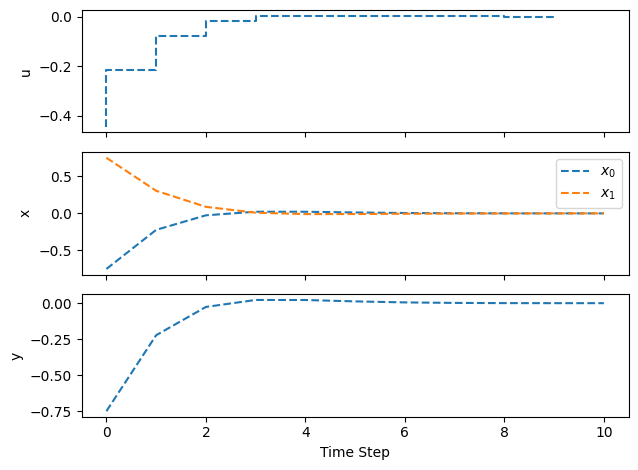

In [14]:
#@title Plot the results of the solution to the optimization problem
#@markdown The trajectories plotted here are the solution to a single solve 
#@markdown of the OCP, thus representing the **open-loop solution**.
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True)
# plot each of the input trajectories
for i in range(Usol.shape[0]):
    ax1.step(Usol[i,:], '--', label=f'$u_{i}$')
if i>0:
    ax1.legend()
# ax1.set_xlabel('Time Step')
ax1.set_ylabel('u')

# plot each of the state trajectories
for i in range(Xsol.shape[0]):
    ax2.plot(Xsol[i,:], '--', label=f'$x_{i}$')
if i>0:
    ax2.legend()
# ax2.set_xlabel('Time Step')
ax2.set_ylabel('x')

# plot each of the output trajectories
for i in range(Ysol.shape[0]):
    ax3.plot(Ysol[i,:], '--', label=f'$y_{i}$')
if i>0:
    ax3.legend()
ax3.set_xlabel('Time Step')
ax3.set_ylabel('y')
plt.tight_layout()
plt.show()

In [15]:
#@title Run a closed-loop simulation
import time
rng = np.random.default_rng(888) # set some random number generator for noise
Nsim = 50 # simulation horizon

# container variables to store the results of each iteration of the simulation
Xsim = np.zeros((nx,Nsim+1)) # state evolution
Ysim = np.zeros((ny,Nsim+1)) # output evolution
Usim = np.zeros((nu,Nsim)) # input evolution
Jsim = np.zeros((1,Nsim)) # cost evolution
Ypredsim = np.zeros((ny,Np+1,Nsim+1)) # predicted states
csim = np.zeros((1,Nsim)) # computation time

Xsim[:,0] = np.ravel(x0) # set the initial state
Ysim[:,0] = np.ravel(h(Xsim[:,0]).full()) + rng.random(size=(ny,))/80.0
# here is a good place to reset the initial guesses of the decision variables if
# you were doing replicates, so that you have repeatability

for k in range(Nsim):
    startTime = time.time()

    # set the parameters of the optimization problem (here it is only the 
    # initial state)
    opti.set_value(X[0], Xsim[:,k])

    # solve optimization problem
    sol = opti.solve()
    # extract results
    Usol = np.asarray([sol.value(u) for u in U]).reshape(nu,-1)
    Ysol = np.asarray([sol.value(y) for y in Y]).reshape(ny,-1)
    # save results
    Usim[:,k] = Usol[:,0] # for control, we are only interested in the first optimal input
    Ypredsim[:,:,k] = Ysol # we can also save the predicted output

    # apply input to system/plant/real system
    Xsim[:,k+1] = np.ravel(f(Xsim[:,k], Usim[:,k]).full())
    # add some process noise
    Xsim[:,k+1] += rng.random(size=(nx,))/50.0 # scale down noise by 50
    Ysim[:,k+1] = np.ravel(h(Xsim[:,k+1]).full())
    # add some measurement noise
    Ysim[:,k+1] += rng.random(size=(ny,))/80.0 # scale down noise by 80

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  88.00us (  6.29us)  53.48us (  3.82us)        14
       nlp_g  | 169.00us ( 12.07us)  95.57us (  6.83us)        14
    nlp_grad  |  26.00us ( 26.00us)  10.35us ( 10.35us)         1
  nlp_grad_f  | 116.00us (  7.25us)  69.51us (  4.34us)        16
  nlp_hess_l  |  48.00us (  4.00us)  30.17us (  2.51us)        12
   nlp_jac_g  | 101.00us (  6.31us)  67.39us (  4.21us)        16
       total  |  11.12ms ( 11.12ms)  14.86ms ( 14.86ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 122.00us (  6.10us)  82.32us (  4.12us)        20
       nlp_g  | 224.00us ( 11.20us) 137.15us (  6.86us)        20
    nlp_grad  |  34.00us ( 17.00us)  18.15us (  9.08us)         2
  nlp_grad_f  | 148.00us (  6.43us)  99.69us (  4.33us)        23
  nlp_hess_l  |  64.00us (  3.76us)  45.13us (  2.65us)        17
   nlp_jac_g  | 129.00us (  5.61us)  95.02us (  4.13us)        23
       tot

Plot results of simulation

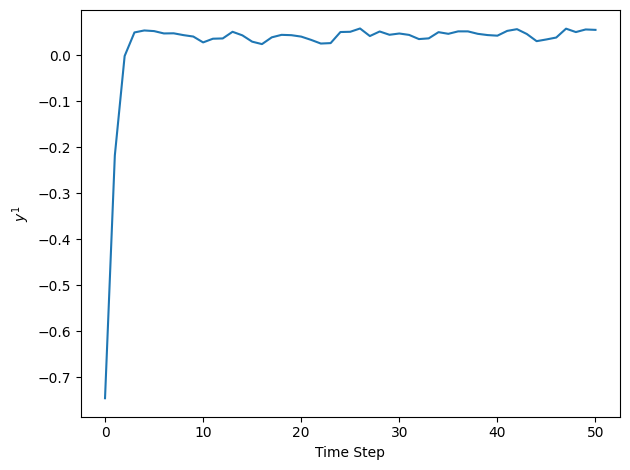

In [16]:
#@title Plot Output
fig, axes = plt.subplots(ny,1, sharex=True)
if ny > 1:
    for i in range(ny):
        axes[i].plot(Ysim[i,:])
        axes[i].set_ylabel(f'$y^{i+1}$')
    axes[i].set_xlabel('Time Step')
else:
    axes.plot(np.ravel(Ysim))
    axes.set_ylabel('$y^1$')
    axes.set_xlabel('Time Step')
plt.tight_layout()
plt.show()

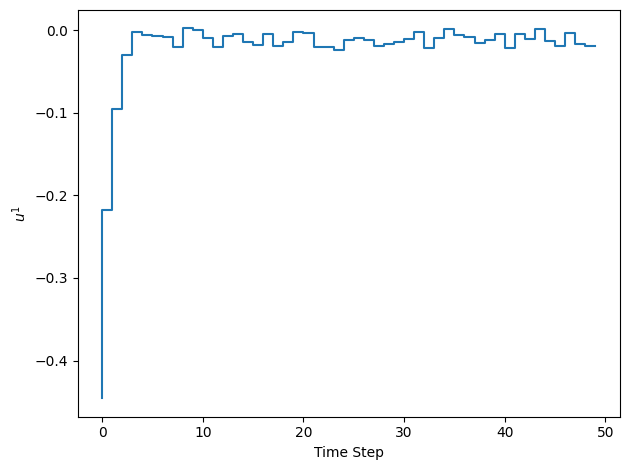

In [17]:
#@title Plot Inputs
fig, axes = plt.subplots(nu,1, sharex=True)
if nu > 1:
    for i in range(nu):
        axes[i].step(Usim[i,:])
        axes[i].set_ylabel(f'$u^{i+1}$')
    axes[i].set_xlabel('Time Step')
else:
    axes.step(np.arange(Usim.shape[1]),np.ravel(Usim))
    axes.set_ylabel('$u^1$')
    axes.set_xlabel('Time Step')
plt.tight_layout()
plt.show()

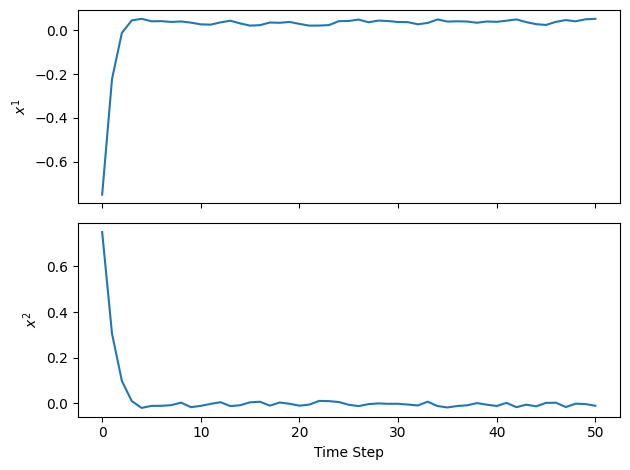

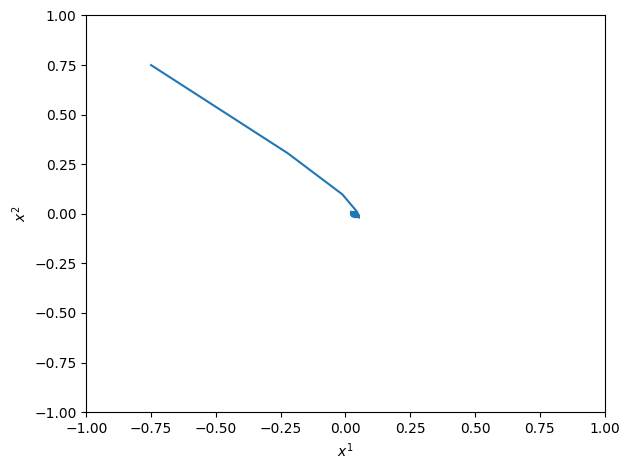

In [18]:
#@title Plot States
fig, axes = plt.subplots(nx,1, sharex=True)
if nx > 1:
    for i in range(nx):
        axes[i].plot(Xsim[i,:])
        axes[i].set_ylabel(f'$x^{i+1}$')
    axes[i].set_xlabel('Time Step')
else:
    axes.plot(np.ravel(Xsim))
    axes.set_ylabel('$x^1$')
    axes.set_xlabel('Time Step')
plt.tight_layout()
plt.draw()

fig, ax = plt.subplots(1,1)
ax.plot(Xsim[0,:], Xsim[1,:])
ax.set_xlabel('$x^1$')
ax.set_ylabel('$x^2$')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
plt.tight_layout()
plt.show()

# Using CasADi's Explicit NLP Formulation

The backend of the Opti tool/interface is CasADi's optimization framework. You may also use this to define optimization problems without the overhead of Opti.

Nonlinear program (NLP)

In [87]:
#@title Formulate the Optimization Problem as an NLP
# Start with an empty NLP
w = [] # empty list to be used to store decision variables
w0 = [] # empty list to be used to store initial guesses of decision variables
lbw = [] # empty list to be used to store the lower bounds of the decision variables
ubw = [] # empty list to be used to store the upper bounds of the decision variables
J = 0 # initialize cost at 0
g = [] # empty list to be used to store the constraints (not related to bounds on decision variables)
lbg = [] # empty list to be used to store the lower bound of the constraints
ubg = [] # empty list to be used to store the upper bound of the constraints

# "Lift" initial conditions
X0 = cas.SX.sym('X_0', nx) # create symbol for the initial state
w += [X0] # add the initial state to the list of decision variables
# bound and set the inital guess of the initial state by its value
lbw += [float(x) for x in x0]
ubw += [float(x) for x in x0]
w0 += [float(x) for x in x0]

# Initial output variable
Y0 = cas.SX.sym('Y_0', ny)
w += [Y0]
lbw += [float(y) for y in ymin]
ubw += [float(y) for y in ymax]
w0 += [0.0]*ny

# Initial output equality constraint; equality constraints are set such that
# the difference of two values is bounded by zero
g   += [Y0 - h(X0)]
lbg += [0.0]*ny
ubg += [0.0]*ny

# Formulate the NLP
Xk = cas.SX(x0)
for k in range(Np):
    # New NLP variable for the control
    Uk = cas.SX.sym(f'U_{k}', nu) # create symbol for input
    w   += [Uk] # add input to the list of decision variables
    # add bounds and set intitial guess
    lbw += [float(u) for u in umin]
    ubw += [float(u) for u in umax]
    w0  += [0.0]*nu

    # Integrate till the end of the interval (get next state)
    Xk_end = f(Xk,Uk)
    J += stage_cost(Xk,Uk)

    # New NLP variable for state at end of interval
    Xk = cas.SX.sym(f'X_{k+1}', nx)
    w   += [Xk]
    lbw += [float('-inf')]*nx
    ubw += [float('inf')]*nx
    w0  += [0.0]*nx

    # NLP variable for the output
    Yk = cas.SX.sym(f'Y_{k+1}', ny)
    w   += [Yk]
    lbw += [float(y) for y in ymin]
    ubw += [float(y) for y in ymax]
    w0  += [0.0]*ny

    # Add equality constraint for the state evolution
    g   += [Xk_end - Xk]
    lbg += [0.0]*nx
    ubg += [0.0]*nx

    # Add equality constraint for the output equation
    g   += [Yk - h(Xk)]
    lbg += [0.0]*ny
    ubg += [0.0]*ny

# Create an NLP solver; define the problem by creating a dictionary with the
# keys 'f', 'x', and 'g', each representing the objective (cost), decision
# variables, and constraints, respectively
prob = {'f': J, 'x': cas.vertcat(*w), 'g': cas.vertcat(*g)}
# Create a solver for the optimization problem
s_opts = {'ipopt.max_iter': 1000,
          'ipopt.print_level': 0,
          'ipopt.tol': 1e-6}
solver = cas.nlpsol('solver', 'ipopt', prob, s_opts)

In [88]:
w

[SX([X_0_0, X_0_1]),
 SX(Y_0),
 SX(U_0),
 SX([X_1_0, X_1_1]),
 SX(Y_1),
 SX(U_1),
 SX([X_2_0, X_2_1]),
 SX(Y_2),
 SX(U_2),
 SX([X_3_0, X_3_1]),
 SX(Y_3),
 SX(U_3),
 SX([X_4_0, X_4_1]),
 SX(Y_4),
 SX(U_4),
 SX([X_5_0, X_5_1]),
 SX(Y_5),
 SX(U_5),
 SX([X_6_0, X_6_1]),
 SX(Y_6),
 SX(U_6),
 SX([X_7_0, X_7_1]),
 SX(Y_7),
 SX(U_7),
 SX([X_8_0, X_8_1]),
 SX(Y_8),
 SX(U_8),
 SX([X_9_0, X_9_1]),
 SX(Y_9),
 SX(U_9),
 SX([X_10_0, X_10_1]),
 SX(Y_10)]

In [89]:
#@title Solve the NLP for the Open Loop Solution to the OCP
sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)

print(sol)

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  72.00us ( 10.29us)  73.00us ( 10.43us)         7
       nlp_g  | 136.00us ( 19.43us) 103.63us ( 14.80us)         7
  nlp_grad_f  |  76.00us (  8.44us)  71.71us (  7.97us)         9
  nlp_hess_l  |  26.00us (  4.33us)  24.27us (  4.04us)         6
   nlp_jac_g  |  78.00us (  9.75us)  74.79us (  9.35us)         8
       total  |  13.53ms ( 13.53ms)  18.94ms ( 18.94ms)         1
{'f': DM(1.52917), 'g': DM([0, 0, 0, 0, -1.04083e-17, 0, 0, 6.93889e-18, 0, 0, -3.46945e-18, 0, 0, 1.73472e-18, -1.73472e-18, 0, 0, 8.67362e-19, 0, -2.1684e-19, 0, 0, -8.13152e-20, -1.0842e-19, 0, 5.42101e-20, 0, 0, 0, -5.42101e-20, 0]), 'lam_g': DM([3.11688e-07, -0.373601, 1.07777, 4.26133e-08, 0.0718858, 0.396862, 4.80955e-09, 0.124749, 0.0958921, -4.02205e-09, 0.0805238, -0.00258653, -3.94184e-09, 0.0371817, -0.0200477, -2.21388e-09, 0.0128319, -0.0146157, -9.26012e-10, 0.00264586, -0.00719762, -2.78133e-10, -0.000413502, -0.0025

Obtain the solution values from the resulting dictionary `sol`; note that the 
dictionary returns the values of ALL decision variables. You will need to 
extract them in the same order that they were created previously.

In [90]:
w_opt = sol['x'].full().flatten()
J_opt = sol['f'].full()

### Extract the Solution

Recall the order that the variables were created:

In [91]:
print(w)

[SX([X_0_0, X_0_1]), SX(Y_0), SX(U_0), SX([X_1_0, X_1_1]), SX(Y_1), SX(U_1), SX([X_2_0, X_2_1]), SX(Y_2), SX(U_2), SX([X_3_0, X_3_1]), SX(Y_3), SX(U_3), SX([X_4_0, X_4_1]), SX(Y_4), SX(U_4), SX([X_5_0, X_5_1]), SX(Y_5), SX(U_5), SX([X_6_0, X_6_1]), SX(Y_6), SX(U_6), SX([X_7_0, X_7_1]), SX(Y_7), SX(U_7), SX([X_8_0, X_8_1]), SX(Y_8), SX(U_8), SX([X_9_0, X_9_1]), SX(Y_9), SX(U_9), SX([X_10_0, X_10_1]), SX(Y_10)]


Note that `MX(X_0)` represents the symbolic representation of $x_0$, i.e., the first predicted state, and that $x_0\in\mathbb{R}^{n_x}$, where $n_x$ is the number of states. The size of `MX(x_0)` is equal to $n_x$ (in this example, recall $n_x=2$). Likewise for the inputs $u$ and outputs $y$.

#### Extract the States

In `w`, the states are the first decision variables and are equally spaced after a number of output $y$ variables and input $u$ variables.

In `w_opt`, all decision variables are flattened together. For the particular example ($n_x = 2$, $n_u = 1$, and $n_y = 1$), the vector `w_opt` follows
$$
w_{opt} = [x^1_0, x^2_0, y^1_0, u^1_0, x^1_1, x^2_1, y^1_1, u^1_1, \ldots, x^1_{N_p-1}, x^2_{N_p-1}, y^1_{N_p-1}, u^1_{N_p-1}, x^1_{N_p}, x^2_{N_p}, y^1_{N_p}].
$$

**Note/Tip:** Indexing in Python has the following conventions:
Let `a` be a list of $n$ entries.
`a[start:stop:step]` can be used to index elements from `a`, where `start` is the index to start indexing at (inclusive), `stop` is the index to stop indexing at (exclusive), and `step` (optional, default is 1) is the spacing or step size to take between consecutive indices.

Examples:
1. The following obtains the first 5 elements of a list `a`
```
a = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
print(a[0:5])
>>> [0, 1, 2, 3, 4]
```
2. The following obtains the fourth to the seventh element of list `a`
```
a = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
print(a[3:7])
>>> [3, 4, 5, 6]
```
3. The following obtains every second element of the list `a` (starting at index 0 until the end of the list).
```
a = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
print(a[::2])
>>> [0, 2, 4, 6, 8]
```
4. The following obtains every second element of the list `a` (starting at index 3 until the eighth index).
```
a = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
print(a[3:8:2])
>>> [3, 5, 7]
```
etc...

In our problem, the spacing between consecutive values of the same state/input/output is $n_x+n_u+n_y$.

In [92]:
space = nx + nu + ny

#@markdown The states begin at the first index for $x^1_k$, the second index for $x^2_k$,
#@markdown ..., for $n_x$ and are spaced $n_x+n_u+n_y$.
x_opt = np.array([w_opt[i::space] for i in range(nx)])
print('Predicted state trajectory shape: ', x_opt.shape)

#@markdown The inputs begin at the $(n_x+n_y)$-th index for $u^1_k$, the next index for $u^2_k$,
#@markdown ..., for $n_u$ and are spaced $n_x+n_u+n_y$.
u_opt = np.array([w_opt[i+nx+ny::space] for i in range(nu)])
print('Predicted input trajectory shape: ', u_opt.shape)

#@markdown The outputs begin at the $n_x$-th index for $y^1_k$, the next index for $y^2_k$,
#@markdown ..., for $n_u$ and are spaced $n_x+n_u+n_y$.
y_opt = np.array([w_opt[i+nx::space] for i in range(ny)])
print('Predicted output trajectory shape: ', y_opt.shape)

Predicted state trajectory shape:  (2, 11)
Predicted input trajectory shape:  (1, 10)
Predicted output trajectory shape:  (1, 11)


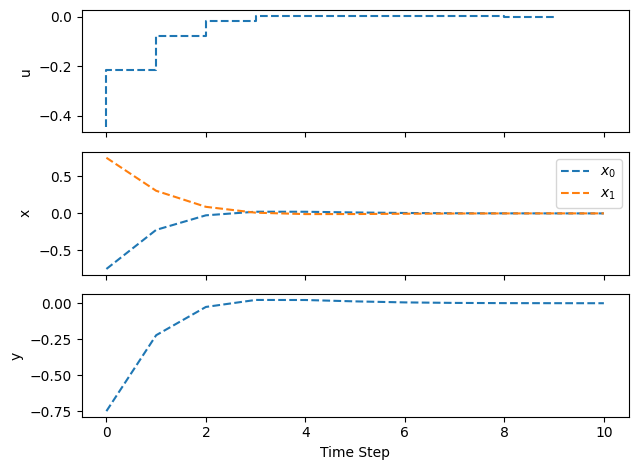

In [93]:
#@title Plot the results of the solution to the optimization problem
#@markdown The trajectories plotted here are the solution to a single solve 
#@markdown of the OCP, thus representing the **open-loop solution**.
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True)
# plot each of the input trajectories
for i in range(nu):
    ax1.step(u_opt[i,:], '--', label=f'$u_{i}$')
if i>0:
    ax1.legend()
# ax1.set_xlabel('Time Step')
ax1.set_ylabel('u')

# plot each of the state trajectories
for i in range(nx):
    ax2.plot(x_opt[i,:], '--', label=f'$x_{i}$')
if i>0:
    ax2.legend()
# ax2.set_xlabel('Time Step')
ax2.set_ylabel('x')

# plot each of the output trajectories
for i in range(ny):
    ax3.plot(y_opt[i,:], '--', label=f'$y_{i}$')
if i>0:
    ax3.legend()
ax3.set_xlabel('Time Step')
ax3.set_ylabel('y')
plt.tight_layout()
plt.show()

In [94]:
#@title Run a closed-loop simulation
rng = np.random.default_rng(888) # set some random number generator for noise
Nsim = 50 # simulation horizon
space = nx + nu + ny

# container variables to store the results of each iteration of the simulation
Xsim = np.zeros((nx,Nsim+1)) # state evolution
Ysim = np.zeros((ny,Nsim+1)) # output evolution
Usim = np.zeros((nu,Nsim)) # input evolution
Jsim = np.zeros((1,Nsim)) # cost evolution
Xpredsim = np.zeros((nx,Np+1,Nsim+1)) # predicted states
Ypredsim = np.zeros((ny,Np+1,Nsim+1)) # predicted outputs
csim = np.zeros((1,Nsim)) # computation time

Xsim[:,0] = np.ravel(x0) # set the initial state
Ysim[:,0] = np.ravel(h(Xsim[:,0]).full()) + rng.random(size=(ny,))/80.0
# here is a good place to reset the initial guesses of the decision variables if
# you were doing replicates, so that you have repeatability

for k in range(Nsim):

    startTime = time.time()
    # solve optimization problem by updating the initial state in the list definitions
    for i in range(nx):
        lbw[i] = float(Xsim[i,k])
        ubw[i] = float(Xsim[i,k])
    w0 = w_opt
    sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)
    endTime = time.time()
    csim[:,k] = endTime - startTime

    # extract solution
    w_opt = sol['x'].full().flatten()
    Jsim[:,k] = sol['f'].full()
    x_opt = np.array([w_opt[i::space] for i in range(nx)])
    u_opt = np.array([w_opt[i+nx+ny::space] for i in range(nu)])
    print(x_opt)
    y_opt = np.array([w_opt[i+nx::space] for i in range(ny)])
    Xpredsim[:,:,k] = x_opt
    Ypredsim[:,:,k] = y_opt
    Usol = u_opt[:,0]

    # save results
    Usim[:,k] = Usol

    # apply input to system/plant/real system
    Xsim[:,k+1] = np.ravel(f(Xsim[:,k], Usim[:,k]).full())
    # add some process noise
    Xsim[:,k+1] += rng.random(size=(nx,))/50.0 # scale down noise by 50
    Ysim[:,k+1] = np.ravel(h(Xsim[:,k+1]).full())
    # add some measurement noise
    Ysim[:,k+1] += rng.random(size=(ny,))/80.0 # scale down noise by 80

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  91.00us (  7.00us)  92.57us (  7.12us)        13
       nlp_g  | 197.00us ( 15.15us) 149.80us ( 11.52us)        13
  nlp_grad_f  | 113.00us (  6.65us) 106.00us (  6.24us)        17
  nlp_hess_l  |  45.00us (  4.09us)  40.01us (  3.64us)        11
   nlp_jac_g  | 105.00us (  7.00us) 103.71us (  6.91us)        15
       total  |   9.40ms (  9.40ms)   9.43ms (  9.43ms)         1
[[-7.50000000e-01 -2.22743418e-01 -2.64315180e-02  2.21124965e-02
   2.16710422e-02  1.21749432e-02  5.09299897e-03  1.52968132e-03
   1.35432822e-04 -3.42183612e-04 -6.03563933e-04]
 [ 7.50000000e-01  3.04513163e-01  8.81106372e-02  8.97739160e-03
  -9.86030023e-03 -9.13189765e-03 -5.03199084e-03 -2.09464446e-03
  -6.93852534e-04 -2.61380335e-04 -2.61380307e-04]]
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 118.00us (  5.90us) 118.19us (  5.91us)        20
       nlp_g  | 275.00us ( 13.75us) 207

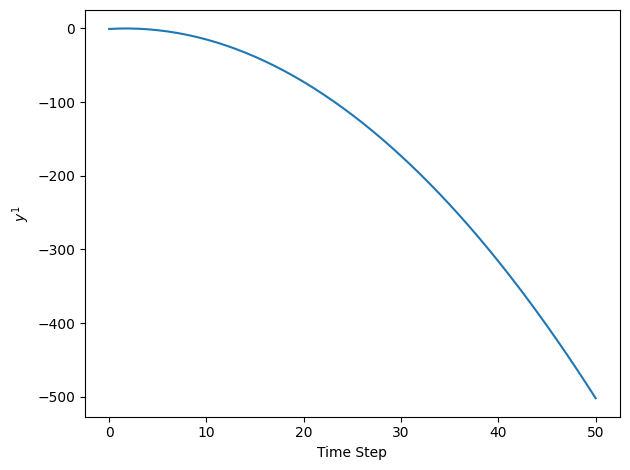

In [95]:
#@title Plot Output
fig, axes = plt.subplots(ny,1, sharex=True)
if ny > 1:
    for i in range(ny):
        axes[i].plot(Ysim[i,:])
        axes[i].set_ylabel(f'$y^{i+1}$')
    axes[i].set_xlabel('Time Step')
else:
    axes.plot(np.ravel(Ysim))
    axes.set_ylabel('$y^1$')
    axes.set_xlabel('Time Step')
plt.tight_layout()
plt.show()

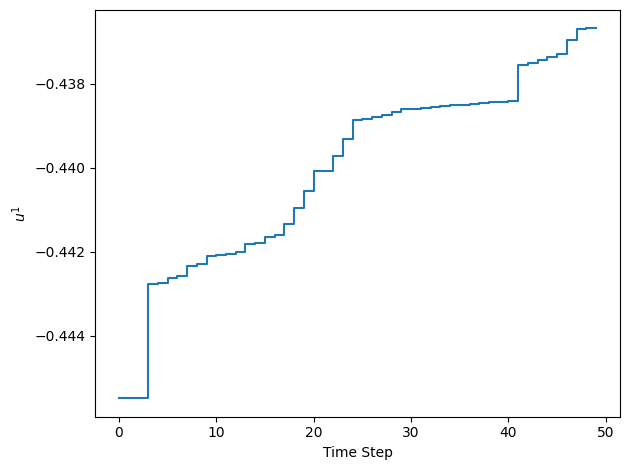

In [96]:
#@title Plot Inputs
fig, axes = plt.subplots(nu,1, sharex=True)
if nu > 1:
    for i in range(nu):
        axes[i].step(Usim[i,:])
        axes[i].set_ylabel(f'$u^{i+1}$')
    axes[i].set_xlabel('Time Step')
else:
    axes.step(np.arange(Usim.shape[1]),np.ravel(Usim))
    axes.set_ylabel('$u^1$')
    axes.set_xlabel('Time Step')
plt.tight_layout()
plt.show()

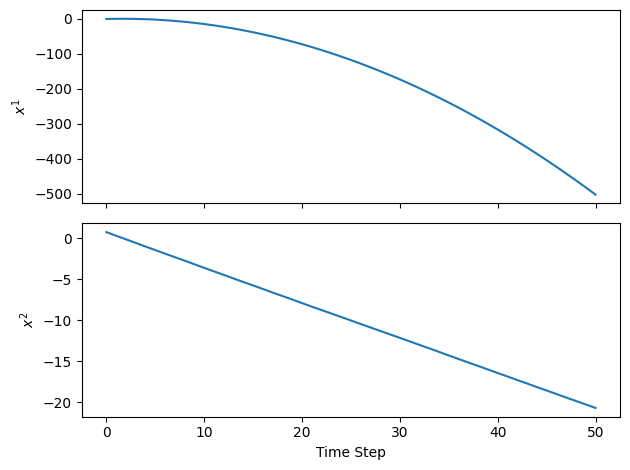

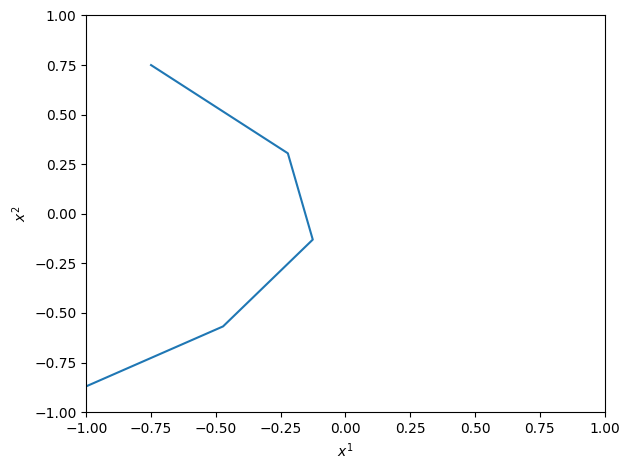

In [97]:
#@title Plot States
fig, axes = plt.subplots(nx,1, sharex=True)
if nx > 1:
    for i in range(nx):
        axes[i].plot(Xsim[i,:])
        axes[i].set_ylabel(f'$x^{i+1}$')
    axes[i].set_xlabel('Time Step')
else:
    axes.plot(np.ravel(Xsim))
    axes.set_ylabel('$x^1$')
    axes.set_xlabel('Time Step')
plt.tight_layout()
plt.draw()

fig, ax = plt.subplots(1,1)
ax.plot(Xsim[0,:], Xsim[1,:])
ax.set_xlabel('$x^1$')
ax.set_ylabel('$x^2$')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
plt.tight_layout()
plt.show()

In [98]:
Ysim

array([[-7.45107742e-01, -2.17673411e-01, -1.15770592e-01,
        -4.67657367e-01, -1.24901479e+00, -2.46405835e+00,
        -4.12112983e+00, -6.20864261e+00, -8.73517421e+00,
        -1.16885521e+01, -1.50843830e+01, -1.89022847e+01,
        -2.31649368e+01, -2.78408242e+01, -3.29670649e+01,
        -3.85352576e+01, -4.45271694e+01, -5.09249096e+01,
        -5.77620965e+01, -6.50348571e+01, -7.27343186e+01,
        -8.08698772e+01, -8.94436568e+01, -9.84363868e+01,
        -1.07825422e+02, -1.17655175e+02, -1.27899176e+02,
        -1.38595021e+02, -1.49692609e+02, -1.61230310e+02,
        -1.73179046e+02, -1.85556733e+02, -1.98366324e+02,
        -2.11597244e+02, -2.25242420e+02, -2.39327417e+02,
        -2.53837786e+02, -2.68789582e+02, -2.84177758e+02,
        -2.99989338e+02, -3.16224070e+02, -3.32877190e+02,
        -3.49962237e+02, -3.67486613e+02, -3.85446209e+02,
        -4.03819294e+02, -4.22623488e+02, -4.41833635e+02,
        -4.61495738e+02, -4.81571414e+02, -5.02072733e+0